In [1]:
import itertools, logging, re, string, sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

sh = logging.StreamHandler(sys.stderr)
sh.setLevel(logging.INFO)
fmt = '%(asctime)s %(message)s'
dfmt = '%y-%m-%d  %H:%M:%S'
logging.basicConfig(handlers=(sh,), format=fmt, datefmt=dfmt, level=logging.INFO)

# Read Data

Read printer data into a DataFrame and subset it into those that already have VIAF IDs and those that don't. 

Plot total texts, texts with IDs, texts without IDs

In [2]:
printers_data_file = 'data/printers_etc.csv'
printers_df = pd.read_csv(printers_data_file)

# This is necessary because some parsedDates have two years (this needs to be fixed)
# So we just keep the first year and then turn the whole column to ints
printers_df['parsedDate'] = printers_df['parsedDate'].str[:4]
printers_df['parsedDate'] = pd.to_numeric(printers_df['parsedDate'])

viaf_exists = printers_df[~printers_df['viafId'].isna()]
viaf_needed = printers_df[printers_df['viafId'].isna()]

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (7,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Total Number of texts:  80,153
Texts with VIAF IDs:    15,927
Texts without VIAF IDs: 64,226


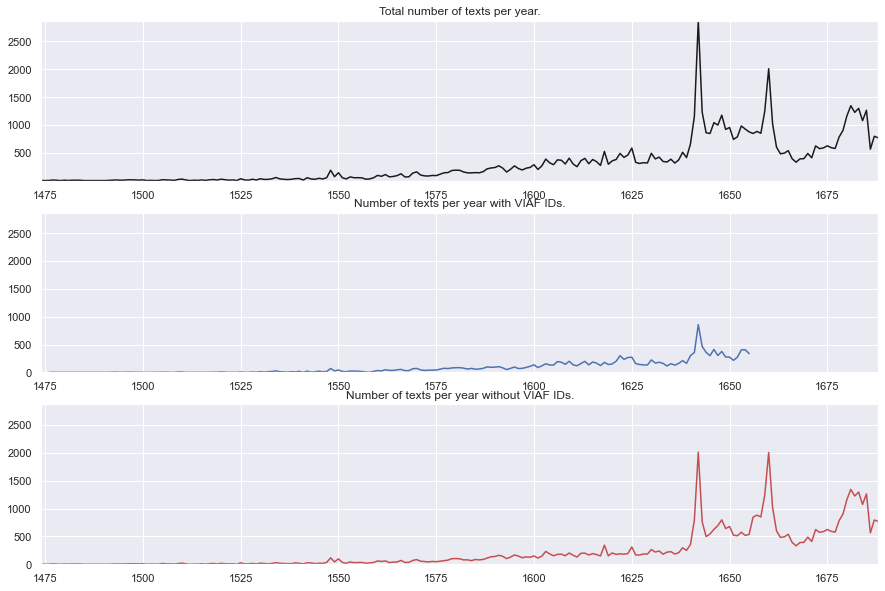

In [3]:
# Change these values to zoom in on shorter yearspans
start_year = 1400
end_year = 1750

total_counts = printers_df.groupby(['parsedDate'])['parsedDate'].count()
viaf_exists_counts = viaf_exists.groupby(['parsedDate'])['parsedDate'].count()
viaf_needed_counts = viaf_needed.groupby(['parsedDate'])['parsedDate'].count()

# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(3,1)
axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[2, 0])]

sns.lineplot(data=total_counts, x=total_counts.index, y=total_counts.values, color='k', ax=axes[0])
sns.lineplot(data=viaf_exists_counts, x=viaf_exists_counts.index, y=viaf_exists_counts.values, color='b', ax=axes[1])
sns.lineplot(data=viaf_needed_counts, x=viaf_needed_counts.index, y=viaf_needed_counts.values, color='r', ax=axes[2])

start_year = start_year if int(total_counts.index[0]) < start_year else int(total_counts.index[0])
end_year = end_year if int(total_counts.index[-1]) > end_year else int(total_counts.index[-1])
axes[0].set(xlim=(start_year, end_year), ylim=(1, max(total_counts.values)), xlabel=None, title='Total number of texts per year.')
axes[1].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year with VIAF IDs.')
axes[2].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year without VIAF IDs.')

print('Total Number of texts:  {:,}\nTexts with VIAF IDs:    {:,}\nTexts without VIAF IDs: {:,}'\
          .format(len(printers_df), len(viaf_exists), len(viaf_needed)))

### Replace viaf_needed with a small subset to speed up testing

In [5]:
viaf_needed

viaf_needed = viaf_needed[:1000]

## Some early Exploration about common misspellings into the database
These numbers may be low but remember this is of the names that have not already been asigned a identifier (i.e. half the database)

So far I compared John-Iohn, William-Wyllyam, and counted number of "me "

In [ ]:
#compare john to iohn
#create a mask for john and John
john_mask = viaf_needed["name"].str.contains("John", case=False)
#count the number of times the mask evaluated to true
john_count = john_mask.sum()
#create a mask for iohn and Iohn
iohn_mask = viaf_needed["name"].str.contains("Iohn", case=False)
#count the number of times the mask evaluated to true
iohn_count = iohn_mask.sum()
print(f"Number of occurrences of 'John' or 'john': {john_count} \n Number of occurrences of 'Iohn' or 'iohn': {iohn_count}")
#compare william to wyllyam (same procedure as above)
will_mask = viaf_needed["name"].str.contains("William", case=False)
will_count = will_mask.sum()
wyyll_mask = viaf_needed["name"].str.contains("Wyllyam", case=False)
wyll_count = wyyll_mask.sum()
print(f"Number of occurrences of 'William' or 'william': {will_count} \n Number of occurrences of 'Wyllyam' or 'wyllyam': {wyll_count}")
#number of occurences of "me " at beginning of name
# Define a regular expression pattern to match "me " at the beginning of each cell. ^ = beginning of the text
pattern = r"^me "
# Count the number of times the pattern occurs in each cell of the "name" column
counts = viaf_needed["name"].str.count(pattern)
# Sum the count of pattern occurrences to get the total count
total_count = counts.sum()
# Print the total count
print("Number of occurrences of 'me ' at the beginning of each cell:", total_count)

# Edit Distance Calculations

The following section uses the python module Levenshtein* to count the edit distance. 
The script works by looping through the list of names and calculating the distance between names. The distance value that is calculated is the number of edits; therefore, fewer edits is better. The number of edits is capped with the threshold variable, and changing this to a lower number will great fewer yet higher fidelity results. 

After calculating the distance the script then creates a list of three closest names that are less than 10 edits away. If there is at least one similar name passing the threshold, it is outputted at the end.

However, the metric is far from perfect. The following sections clean the data for better results.

*The Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. [Wikiapedia](https://en.wikipedia.org/wiki/Levenshtein_distance) 

In [ ]:
#levenshtein (edit) distance
import Levenshtein

# Get a list of unique names in the "Name" column
names = viaf_needed["name"].unique()

# Create an empty dictionary to store the results
result_dict = {}

# Set the maximum number of edits allowed between the names
threshold = 10

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        # Calculate the Levenshtein distance between the two names
        distance = Levenshtein.distance(name, name2, weights=(2,2,1))
        
        # Store the distance in the distances list
        if distance < threshold:
            distances.append((name2, distance))
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")


# Improving Levenshtein

The following section improves on the process by removing "me " from the beginning of the names column and by removing all punctuation

It also reduces the total number of edits allowed (i.e. threshold) to create higher fidelity results.

In [ ]:
#levenshtein (edit) distance (without "me ")
viaf_needed["name"] = viaf_needed["name"].str.replace("^me ", "", regex=True)

#remove punctuation
punctuation = string.punctuation

viaf_needed["name"] = viaf_needed["name"].str.replace(f"[{punctuation}]", "",regex=True)

# Get a list of unique names in the "Name" column
names = viaf_needed["name"].unique()

# Create an empty dictionary to store the results
result_dict = {}

# Set the maximum number of edits allowed between the names
threshold = 4

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        # Calculate the Levenshtein distance between the two names
        distance = Levenshtein.distance(name, name2, weights=(2,2,1))
        
        # Store the distance in the distances list
        if distance < threshold:
            distances.append((name2, distance))
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")

# Name Spliting function

Let's put in all the preprocessing steps into the name_preprocess function so that we can just call it on a name and get as close to a clean (firstname, lastname) tuple as possible.

Below are two functions. name_preprocess tries to remove erroneous names while name_preprocess just separates the string based on the first whitespace

Example output:<br>
John Smith -> ('John', 'Smith')<br>
John. Smyth -> ('John', 'Smyth')<br>
Wynken de Worde -> ('Wynken', 'de Worde')<br>
'printed at the sign of the fox' -> None (i.e. doesn't look like a legit name)

#### Note: A trick to try later. Learn the vocabulary used in all name strings and ignore frequently used words like 'active' etc

In [17]:
#remove 'me' and punctuation
punctuation = string.punctuation
viaf_needed.loc[:, "name"] = viaf_needed["name"].str.replace("^me ", "", regex=True)
viaf_needed.loc[:, "name"] = viaf_needed["name"].str.replace(f"[{punctuation}]", "",regex=True)

def name_preprocess(full_name, max_length=30, min_tokens=2, max_tokens=4):
    #ignore names that are too long
    if len(full_name) > max_length:
        logging.info(f'Too long: Ignoring: {full_name}')
        return None
    #find all strings separated by whitespace
    words = re.findall(r'\b\w+\b', full_name)
    # check if the number of words is at least 2 or over 4
    if len(words) < min_tokens:
        logging.info(f'Too few tokens: Ignoring: {full_name}')
        return None
    if len(words) > max_tokens:
        logging.info(f'Too many tokens: Ignoring: {full_name}')
        return None
    # return the first word and remaining string as a tuple
    first_name = words[0].lower()
    last_name = ' '.join(words[1:]).lower()
    return (first_name, last_name)

# simple function that splits name
def name_preprocess_simple(full_name):
    words = re.findall(r'\b\w+\b', full_name)
    first_name = words[0]
    last_name = ' '.join(words[1:])
    return (first_name, last_name)

# Using Strsimpy

In order to further improve the levenshtein we can use another python module called strsimpy which allows us to weight the subsitutions. Below we set reduced costs for certain common letter replacements.

Key goal heare is to reduce the number of name-pairs we run through the Weighted Levenshtein function.

We'll parse names into (firstname, lastname) tuples. Then, for each pair we should check firstname against firstname and lastname against lastname. We retain a pair if 1> First and Lastnames start with the same initials, 2> They are roughly same in length (these criteria need to be refined later)

In [18]:
from strsimpy.weighted_levenshtein import WeightedLevenshtein

substitution_cost_dict = {('i', 'j'): 0.5,
                          ('j', 'i'): 0.5,
                          ('u', 'v'): 0.3,
                          ('v', 'u'): 0.3}

weighted_levenshtein = WeightedLevenshtein(substitution_cost_fn=lambda x, y: substitution_cost_dict[(x,y)] if (x, y) in substitution_cost_dict else 1.0)

# Get a list of unique names in the "Name" column
names = [name_preprocess(name) for name in viaf_needed["name"].unique() if name_preprocess(name)!=None]

name_pairs = itertools.combinations(names, 2)
name_pairs = [((f1, l1), (f2, l2)) for (f1, l1), (f2, l2) in name_pairs if ((f1[0]==f2[0]) and (l1[0]==l2[0]))]

print(f'Total number if name-pairs to compute distances on: {len(name_pairs)}')
print(name_pairs[:10])

23-02-18  17:43:16 Too long: Ignoring: Caxton William approximately 14221491 or 1492
23-02-18  17:43:16 Too long: Ignoring: Rivers Anthony Woodville Earl of 1442 1483
23-02-18  17:43:16 Too long: Ignoring: s lettou et Willes de machlinia i citate Londoniarum
23-02-18  17:43:16 Too long: Ignoring: Wilhelmum de Mechlinia impressus
23-02-18  17:43:16 Too long: Ignoring: one some tyme scole mayster of saynt Albons vppon whoos soule god haue mercy Amen And newely
23-02-18  17:43:16 Too long: Ignoring: the fron ballaunce ampc Emprinted
23-02-18  17:43:16 Too long: Ignoring: the comaundement of the reuerend faher i god
23-02-18  17:43:16 Too long: Ignoring: Fox Richarde approximately 1447
23-02-18  17:43:16 Too long: Ignoring: care and charges of IohannCarl Vnckels a booke seller
23-02-18  17:43:16 Too long: Ignoring: Andrew Laurence active 15101537
23-02-18  17:43:16 Too long: Ignoring: Copeland Robert active 15081547
23-02-18  17:43:16 Too long: Ignoring: Berners John Bourchier Lord 1466 or

Total number if name-pairs to compute distances on: 591
[(('colard', 'mansion'), ('coverdale', 'miles 1488 1568')), (('william', 'caxton'), ('wyllyam', 'caxton')), (('william', 'caxton'), ('w', 'copland')), (('william', 'caxton'), ('wyllyam', 'copland')), (('william', 'caxton'), ('wylliam', 'copland')), (('trevisa', 'john 1402'), ('trevisa', 'johncd 1402')), (('wyllyam', 'caxton'), ('w', 'copland')), (('wyllyam', 'caxton'), ('wyllyam', 'copland')), (('wyllyam', 'caxton'), ('wylliam', 'copland')), (('richard', 'pynson'), ('rycharde', 'pynson'))]


In [ ]:
# dictionaries to store the results and distances
result_dict = {}
distance_cache = {}

# Set the maximum number of edits allowed between the names
threshold = 6

for (f1, l1), (f2, l2) in name_pairs:
    distance = weighted_levenshtein.distance(f1, f2) + weighted_levenshtein.distance(l1, l2)
    
    # The section below needs work -- I'm leaving it unchanged
    
    
            # Store the result in the cache
            if name2 not in distance_cache:
                distance_cache[name2] = {}
            distance_cache[name2][name] = distance
        
        # Store the distance in the distances list if it's below the threshold
        if distance < threshold:
            distances.append((name2, distance))
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")


In [ ]:
# Leaving the old code here temporarily

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        if name == name2:
            continue
        # check if lengths are of a distance greater than threshold. IF so can skip
        if abs(len(name)-len(name2)) > threshold:
            continue
        # Check if the result is already in the cache
        if name2 in distance_cache and name in distance_cache[name2]:
            distance = distance_cache[name2][name]
        else:
            # Calculate the Levenshtein distance between the two names
            distance = weighted_levenshtein.distance(name, name2)
            
            # Store the result in the cache
            if name2 not in distance_cache:
                distance_cache[name2] = {}
            distance_cache[name2][name] = distance
        
        # Store the distance in the distances list if it's below the threshold
        if distance < threshold:
            distances.append((name2, distance))
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")


In [4]:
viaf_needed

,tcpid,role,role_edited,name,source,title,author,parsedDate,date,place,pubStmt,nameResolved,viafId
0,A18343,printer,printer,Colard Mansion,tcp_ep,"[T]o the right noble, right excellent [and] ve...","Jacobus, de Cessolis, fl. 1288-1322",1474.0,1474 (31 March)],NaN,"Printed by William Caxton and Colard Mansion, ...",NaN,NaN
1,A18343,printer,printer,William Caxton,tcp_ep,"[T]o the right noble, right excellent [and] ve...","Jacobus, de Cessolis, fl. 1288-1322",1474.0,1474 (31 March)],NaN,"Printed by William Caxton and Colard Mansion, ...",NaN,NaN
2,A06567,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,Stans puer ad mensam,"Lydgate, John, 1370?-1451?",1476.0,1476?],NaN,"Printed by William Caxton, [Westminster : 1476?]",NaN,NaN
4,A18231,printer,printer,William Caxton,tcp_ep,Hic incipit paruus Catho,"Cato, Marcus Porcius, 234-149 B.C., attributed...",1476.0,1476],NaN,"Printed by William Caxton, [Westminster : 1476]",NaN,NaN
5,A06543,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,[The chorle and the birde],"Lydgate, John, 1370?-1451?",1477.0,1477?],NaN,"W. Caxton, [Westminster : 1477?]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80148,B43983,publisher,publisher,J. Clarke,tcp_ep,Shrowsbury for me: being a song in praise of t...,NaN,NaN,[between 1681 and 1684],NaN,"Printed for J. Wright, J. Clarke, W. Thackeray...",NaN,NaN
80149,B43983,publisher,publisher,J. Wright,tcp_ep,Shrowsbury for me: being a song in praise of t...,NaN,NaN,[between 1681 and 1684],NaN,"Printed for J. Wright, J. Clarke, W. Thackeray...",NaN,NaN
80150,B43983,publisher,publisher,T. Passenger,tcp_ep,Shrowsbury for me: being a song in praise of t...,NaN,NaN,[between 1681 and 1684],NaN,"Printed for J. Wright, J. Clarke, W. Thackeray...",NaN,NaN
80151,B43983,publisher,publisher,W. Thackeray,tcp_ep,Shrowsbury for me: being a song in praise of t...,NaN,NaN,[between 1681 and 1684],NaN,"Printed for J. Wright, J. Clarke, W. Thackeray...",NaN,NaN


In [10]:
substitution_cost_dict = {('i', 'j'):.5}

def test():
    print(f('i', 'k'))

test()

1.0


In [ ]:
def substitution_cost(char_a, char_b):
    if char_a == 'j' and char_b == 'i':
        return 0.5
    if char_a == 'y' and char_b == 'i':
        return 0.5
    if char_a == 'u' and char_b == 'v':
        return 0.5
    # in my look at the data the below substitutions were a frequent but less common subsitution
    # so I included them but increased the weight a little than the very common above cases
    if char_a == 'y' and char_b == 'e':
        return 0.75
    if char_a == 'u' and char_b == 'w':
        return 0.75
    return 1.0

